In [10]:
# Imports

%matplotlib inline  
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
from matplotlib.collections import LineCollection

In [11]:
#Constants and Vars

DATA_FILE = 'data/driving_log.csv'
STEERING_CONST = -5.0

In [12]:
# Preprocess CSV file from Unity Simulator
def preprocess(data_file):
    df = pd.read_csv(data_file,header=None, names=['date', 'steering', 'throttle', 'brake', 'velocity', 'rpm', 'torque'])
    df['date'] = df['date'].apply(lambda x: int(datetime.strptime(x, '%Y_%m_%d_%H_%M_%S_%f').timestamp()*1000))
    df['time'] = (df.date - df.date.iloc[0])/1000.0
    df['time_diff'] = df.time.diff()
    
    return df

In [13]:
data = preprocess(DATA_FILE)

# Add dimensions needed to track position
data['distance'] = data.velocity * data.time_diff
data['rel_steering'] = data.steering * STEERING_CONST * data.distance
data['abs_steering'] = data.rel_steering.cumsum()
data['rel_x'] = np.cos(np.deg2rad(data.abs_steering)) * data.distance
data['rel_y'] = np.sin(np.deg2rad(data.abs_steering)) * data.distance
data['abs_x'] = data.rel_x.cumsum()
data['abs_y'] = data.rel_y.cumsum()

In [90]:
# OPTIONAL: Output processed csv file

data.to_csv('data.csv')

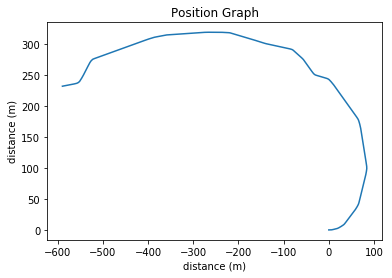

In [16]:
# Plot path (x,y)
plt.figure()
plt.title('Position Graph')
plt.ylabel('distance (m)')
plt.xlabel('distance (m)')
plt.plot(data.abs_x, data.abs_y)

Text(0.5,0,'time (s)')

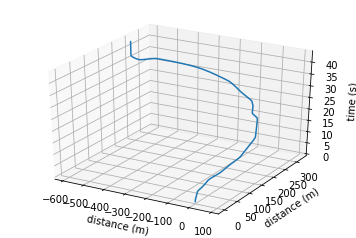

In [26]:
# Position vs. Time graph

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs=data.abs_x, ys=data.abs_y, zs=data.time)
ax.set_xlabel('distance (m)')
ax.set_ylabel('distance (m)')
ax.set_zlabel('time (s)')

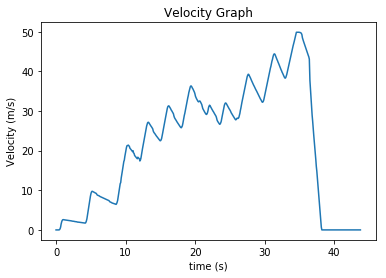

In [27]:
plt.figure()
plt.title('Velocity Graph')
plt.ylabel('Velocity (m/s)')
plt.xlabel('time (s)')
plt.plot(data.time, data.velocity)

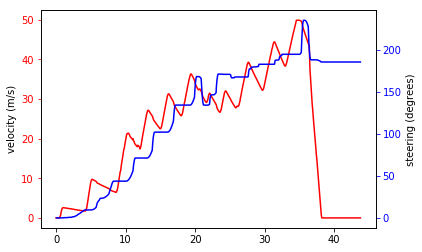

In [21]:
# Subplots with velocity & steering vs time
fig, ax = plt.subplots()

axes = [ax, ax.twinx()]
dp = [data.time, data.time]
dp2 = [data.velocity, data.abs_steering]
y_axis = ["velocity (m/s)", "steering (degrees)"]

colors = ('Red', 'Blue')
for ax, color, d, d2, y in zip(axes, colors, dp, dp2, y_axis):
    ax.plot(d, d2, color=color)
    ax.set_ylabel(y)
    ax.tick_params(axis='y', colors=color)
plt.show()

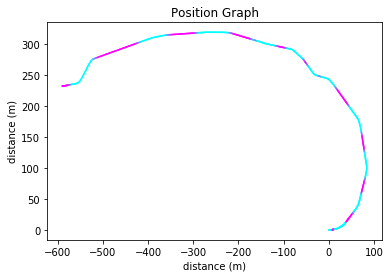

In [22]:
# Position Graph with dynamic colors for aggressiveness (throttle)
cm = plt.get_cmap('cool') 
cNorm  = cpl.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
xy = [[xx, yy] for (xx,yy) in zip(data.abs_x, data.abs_y)]
for start, stop, tt in zip(xy[:-1], xy[1:], data.throttle[:-1]):
    x, y = zip(start, stop)
    colorVal = scalarMap.to_rgba(tt)
    ax.plot(x, y, color=colorVal)
    
plt.title('Position Graph')
plt.ylabel('distance (m)')
plt.xlabel('distance (m)')
plt.show()

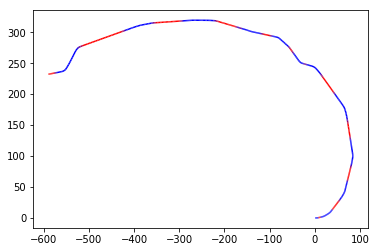

In [28]:
# Position Graph with custom colormap for aggressiveness (throttle)

# cm = plt.get_cmap('cool') 
cdict = {'red':   [(0.0,  0.0, 0.0),
#                    (0.5,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
#                    (0.25, 0.0, 0.0),
#                    (0.75, 1.0, 1.0),
                   (1.0,  0.0, 0.0)],

         'blue':  [(0.0,  1.0, 1.0),
#                    (0.5,  1.0, 1.0),
#                    (0.75,  0.0, 0.0),
                   (1.0,  0.0, 0.0)]}

# cm = cpl.LinearSegmentedColormap.from_list("", ["blue","violet","red"])
cm = cpl.LinearSegmentedColormap("", cdict)
cNorm  = cpl.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

xy = [[xx, yy] for (xx,yy) in zip(data.abs_x, data.abs_y)]#(data.abs_x, data.abs_y)

xy = [ [x0, x1] for x0, x1 in zip(xy[:-1], xy[1:])]
cSegments = [scalarMap.to_rgba(c) for c in data.throttle]
fig, ax = plt.subplots()
coll = LineCollection(xy, color=cSegments)

ax.add_collection(coll)
ax.autoscale_view()

plt.show()